# Best Run

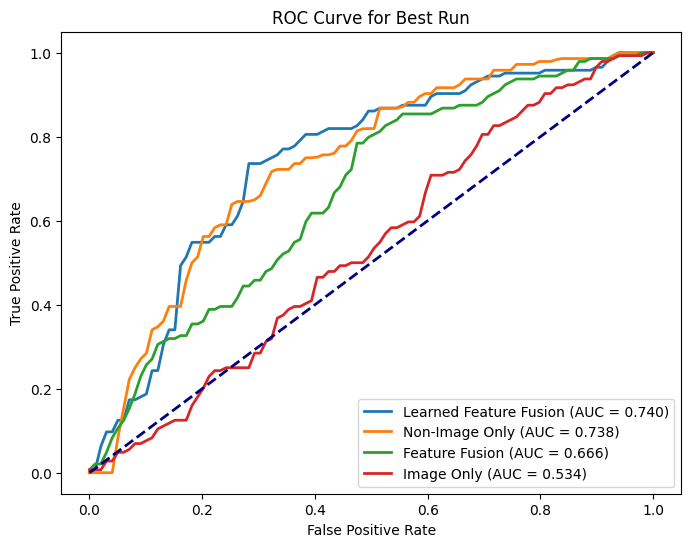

In [1]:
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

file_info = [
    ('/content/best/feature-fusion_no-CW_aug_seed2.csv', 'Feature Fusion'),
    ('/content/best/image-only_no-CW_aug_seed0.csv', 'Image Only'),
    ('/content/best/learned-feature-fusion-concat_no-CW_aug_seed2.csv', 'Learned Feature Fusion'),
    ('/content/best/non-image-only_no-CW_seed4.csv', 'Non-Image Only')
]

plt.figure(figsize=(8, 6))

auc_info = []
for file_path, model_name in file_info:
    data = pd.read_csv(file_path)
    y_true = data['y_true']
    y_prob = data['y_prob']

    fpr, tpr, thresholds = roc_curve(y_true, y_prob)

    fpr_final = np.linspace(0, 1, 100)
    tpr_final = np.interp(fpr_final, fpr, tpr)

    roc_auc = roc_auc_score(y_true, y_prob)

    auc_info.append((model_name, roc_auc))

auc_info.sort(key=lambda x: x[1], reverse=True)


for model_name, roc_auc in auc_info:
    for file_path, original_model_name in file_info:
        if original_model_name == model_name:
            data = pd.read_csv(file_path)
            y_true = data['y_true']
            y_prob = data['y_prob']

            fpr, tpr, thresholds = roc_curve(y_true, y_prob)
            fpr_final = np.linspace(0, 1, 100)
            tpr_final = np.interp(fpr_final, fpr, tpr)

            plt.plot(fpr_final, tpr_final, lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Best Run')
plt.legend(loc='lower right')
plt.show()


# Five-Run Ensemble

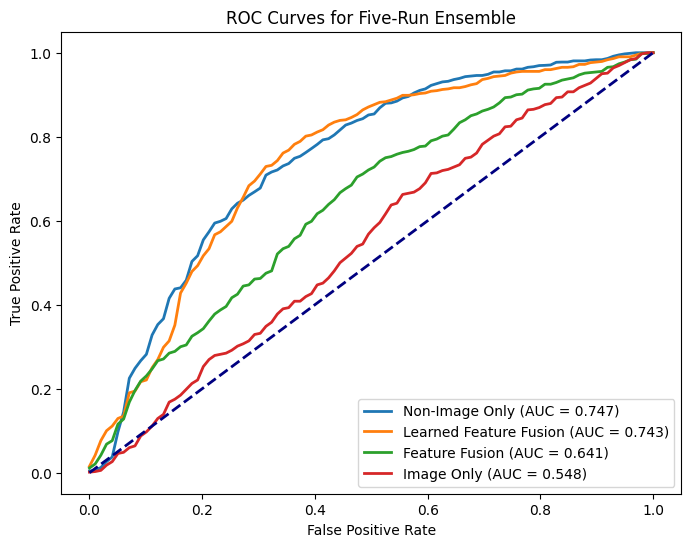

In [2]:
import os
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

data_dir = '/content/allModels'

model_names = ['Feature Fusion', 'Image Only', 'Learned Feature Fusion', 'Non-Image Only']

roc_data = {model: {'fpr': None, 'tpr': []} for model in model_names}
common_fpr = np.linspace(0, 1, 100)

auc_values = []

for model_dir in os.listdir(data_dir):
    if not os.path.isdir(os.path.join(data_dir, model_dir)):
        continue

    if model_dir == '.ipynb_checkpoints':
        continue

    model_name = model_dir  # Model name is the same as the directory name

    all_tpr = []

    for file_name in os.listdir(os.path.join(data_dir, model_dir)):
        if file_name.endswith('.csv'):
            data = pd.read_csv(os.path.join(data_dir, model_dir, file_name))
            y_true = data['y_true']
            y_prob = data['y_prob']

            fpr, tpr, thresholds = roc_curve(y_true, y_prob)

            tpr_interpolated = np.interp(common_fpr, fpr, tpr)

            all_tpr.append(tpr_interpolated)

    mean_tpr = np.mean(all_tpr, axis=0)

    roc_data[model_name]['fpr'] = common_fpr
    roc_data[model_name]['tpr'] = mean_tpr

    roc_auc = auc(common_fpr, mean_tpr)
    auc_values.append((model_name, roc_auc))

auc_values.sort(key=lambda x: x[1], reverse=True)

plt.figure(figsize=(8, 6))

for model_name, auc_score in auc_values:
    data = roc_data[model_name]
    if data['fpr'] is not None:
        plt.plot(data['fpr'], data['tpr'], lw=2, label=f'{model_name} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Five-Run Ensemble')
plt.legend(loc='lower right')
plt.show()